In [9]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Custom modules and functions
from capstone.model_selection import (
    overunder_error, 
    ts_cross_val_score
)

from capstone.portfolio.metrics import Metrics
from capstone.utils import (
    read_file, 
    save_models, 
    get_sectors, 
    set_plot_style
)

# Machine learning and modeling tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor
)
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

# Progress bar for loops
from tqdm.auto import tqdm

set_plot_style()

In [10]:
# Load files
df = read_file("master_df", index_col="Date")
sectors = get_sectors()

df.index.min(), df.index.max(), df.shape

(Timestamp('2006-11-17 00:00:00'),
 Timestamp('2023-09-11 00:00:00'),
 (4230, 120))

In [11]:
# Separate the combined dataframe into targets (sector average returns) and features
targets = df[sectors]
features = df[df.columns[~df.columns.isin(sectors)]]

features.shape, targets.shape

((4230, 109), (4230, 11))

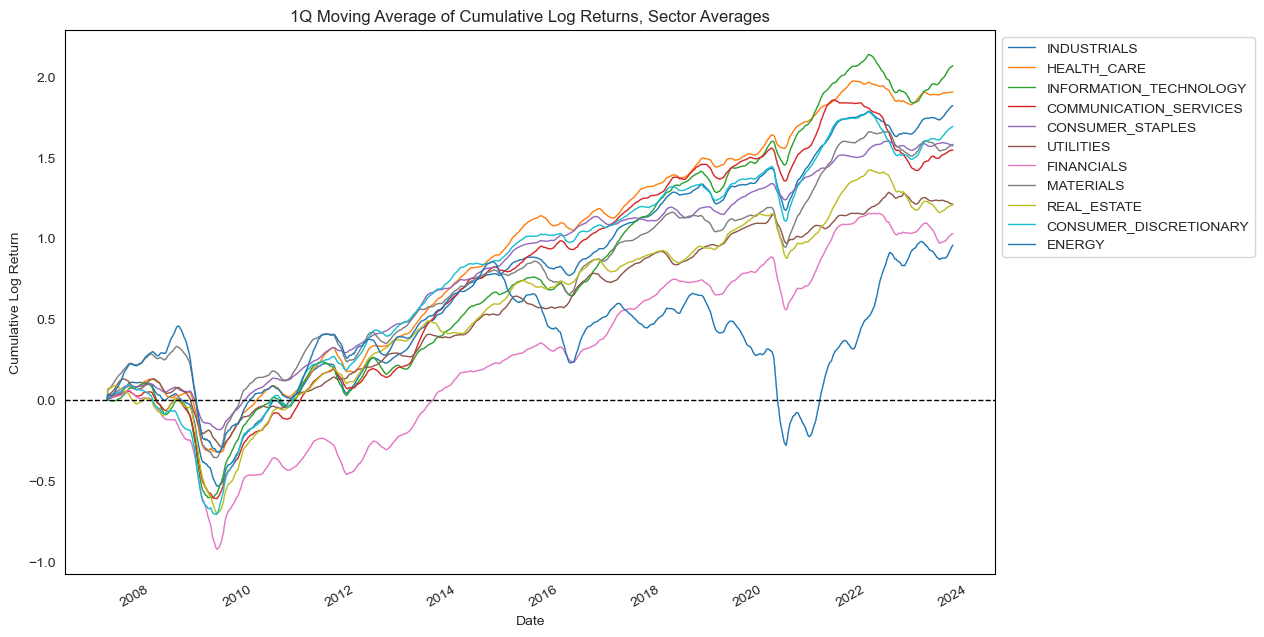

In [12]:
# Plot rolling n average of sector average cumulative return
n=63
sector_cum_ret_ma = targets.cumsum().rolling(n).mean()
sector_cum_ret_ma.loc[sector_cum_ret_ma.first_valid_index()] = 0
sector_cum_ret_ma.plot(figsize=(12, (12*(2/3))), grid=False)
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title(f"{n//63}Q Moving Average of Cumulative Log Returns, Sector Averages")
plt.ylabel("Cumulative Log Return")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

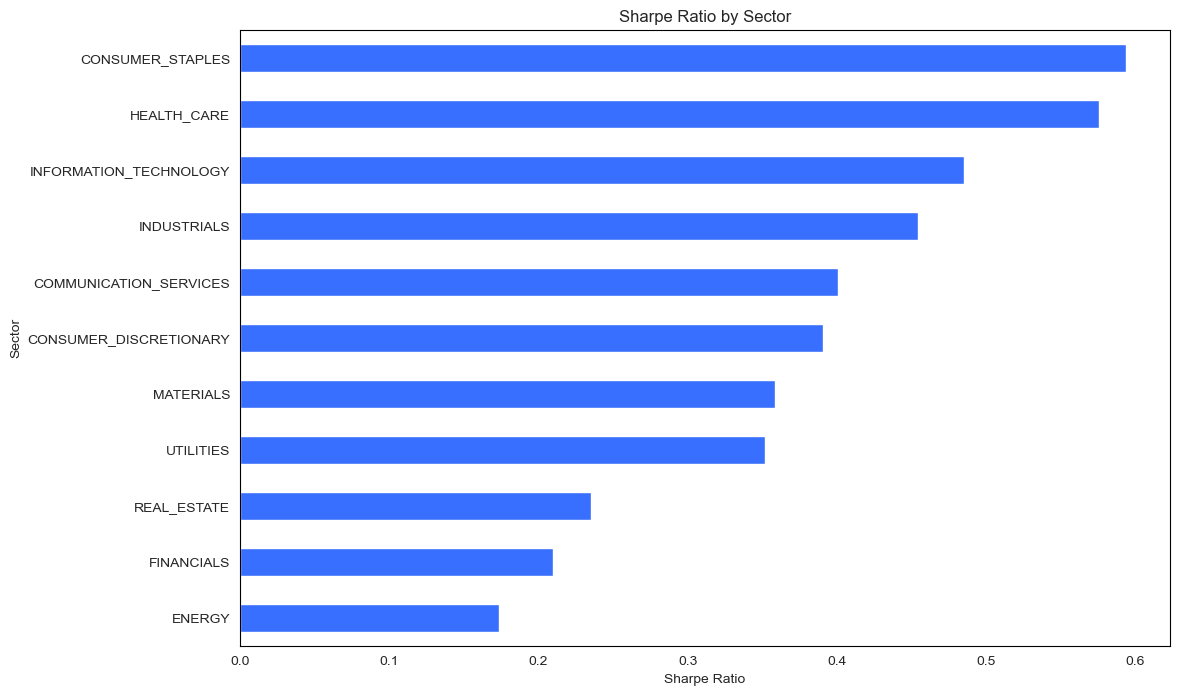

In [13]:
# Compute metrics for sector averages and plot Sharpe ratios
metrics = Metrics()
metric = "Sharpe Ratio"
sector_metrics = metrics.calculate(targets).sort_values(by=metric)

sector_metrics[metric].plot.barh(
    figsize=(12, (12*(2/3))),
    grid=False,
    color="#396FFF",
)

plt.title(f"{metric} by Sector")
plt.ylabel("Sector")
plt.xlabel("Sharpe Ratio")
plt.show()

In [14]:
# Intitialize PCA, explaining >= 80% of the variance
pca = PCA(n_components=.8, random_state=42)

# Initialize a standard scaler
scaler = StandardScaler()

# Create a dictionary of regression models designed for working with stock returns
models = {
    # ElasticNet combines L1 and L2 regularization, suitable for feature selection and dealing with multicollinearity.
    'ElasticNet': make_pipeline(scaler, pca, ElasticNet(alpha=1, l1_ratio=0.5, random_state=42)),
    
    # Support Vector Regressor (SVR) with an RBF kernel can capture non-linear relationships in stock returns.
    'SVR': make_pipeline(scaler, pca, SVR(kernel='rbf', C=1, gamma='auto')),
    
    # RandomForestRegressor is an ensemble method that can capture complex relationships and feature importance.
    'RandomForest': make_pipeline(scaler, pca, RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)),
    
    # GradientBoostingRegressor is another ensemble method suitable for capturing non-linear relationships and trends.
    'GradientBoost': make_pipeline(scaler, pca, GradientBoostingRegressor(n_estimators=100, random_state=42)),
    
    # XGBoostRegressor is an optimized gradient boosting algorithm known for its speed and performance.
    'XGBoost': make_pipeline(scaler, pca, XGBRegressor(n_estimators=100, random_state=42)),
}

# Explanation for parameter choices:

# ElasticNet Parameters:
#   - alpha=1: Strong regularization to prevent overfitting.
#   - l1_ratio=0.5: Balanced mix of L1 (Lasso) and L2 (Ridge) regularization.
#   - random_state=42: Ensures reproducible results.

# SVR Parameters:
#   - kernel='rbf': RBF kernel to capture non-linear stock return relationships.
#   - C=1: Moderate regularization to control model complexity.
#   - gamma='auto': Automatic kernel coefficient selection based on data.

# RandomForestRegressor Parameters:
#   - n_estimators=100: 100 decision trees balance complexity and predictive power.
#   - max_depth=3: Shallow trees to prevent overfitting.
#   - random_state=42: Ensures reproducible ensemble results.

# GradientBoostingRegressor Parameters:
#   - n_estimators=100: 100 boosting stages capture complex relationships.
#   - random_state=42: Ensures reproducible ensemble results.

# XGBoostRegressor Parameters:
#   - n_estimators=100: 100 boosting rounds balance performance and efficiency.
#   - random_state=42: Ensures reproducible results with XGBoost.

In [15]:
# Save models
save_models(models)

In [16]:
# Set the forecast horizon to 126 days (approx. 1/2 trading year)
forecast = 126

# Shift the features to match the forecast horizon and remove NA rows
X_shifted = features.shift(forecast).dropna()

# Reindex the target data to align with the shifted features
y_all = df[sectors].reindex(X_shifted.index)

# Initialize empty DataFrames to store model predictions and Over-Under loss (OUL)
preds = {model: pd.DataFrame() for model in models.keys()}
ouls = {model: pd.DataFrame() for model in models.keys()}

# Loop through each sector in the target data
for sector in tqdm(y_all.columns):
    
    # Loop through each machine learning model
    for name, model in models.items():

        # Copy the target data for the current sector
        y = y_all[sector]

        # Loop through the data in steps of 'forecast' days
        for i in range(forecast, len(y), forecast):
            
            # Split the data into rolling windows for training and testing
            X_train = X_shifted.iloc[i-forecast:i]
            X_test = X_shifted.iloc[i:i+forecast]
            y_train = y.iloc[i-forecast:i]
            y_test = y.iloc[i:i+forecast]

            # Conduct cross validation
            mean_oul = np.mean(
                ts_cross_val_score(
                    model, 
                    X_train, 
                    y_train, 
                    cv=2, 
                    scorer=overunder_error, 
                    underpred_penalty=0,
                    overpred_penalty=2
                )
            )
            
            # Take the mean of the OULs
            ouls[name].loc[X_test.index.min(), sector] = mean_oul

            # Fit the model on the full rolling training window and predict on the test set
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            
            # Store the mean of the predicted values (predicted logarithmic returns)
            preds[name].loc[X_test.index.min(), sector] = np.mean(y_hat)

        # Ensure predictions and ouls to float type
        preds[name][sector] = preds[name][sector].astype(float)
        ouls[name][sector] = ouls[name][sector].astype(float)

  0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Determine the sector with the maximum value across time
sklearn_best_sectors = {model: pd.Series(pred.idxmax(axis=1), name=model) for model, pred in preds.items()}

# Concatenate the Series from each model into a single DataFrame
sklearn_best_sectors = pd.concat([pred for pred in sklearn_best_sectors.values()], axis=1)

# Display the first few rows of the model_preds DataFrame
sklearn_best_sectors.head()

,ElasticNet,SVR,RandomForest,GradientBoost,XGBoost
2007-11-20,ENERGY,INDUSTRIALS,UTILITIES,UTILITIES,UTILITIES
2008-05-22,ENERGY,CONSUMER_DISCRETIONARY,ENERGY,UTILITIES,COMMUNICATION_SERVICES
2008-11-19,CONSUMER_STAPLES,UTILITIES,REAL_ESTATE,REAL_ESTATE,REAL_ESTATE
2009-05-22,CONSUMER_DISCRETIONARY,UTILITIES,REAL_ESTATE,REAL_ESTATE,CONSUMER_DISCRETIONARY
2009-11-19,REAL_ESTATE,INDUSTRIALS,INFORMATION_TECHNOLOGY,COMMUNICATION_SERVICES,CONSUMER_DISCRETIONARY


In [ ]:
# Calculate the mean of each DataFrame in the 'ouls' dictionary along the rows
sklearn_mean_ouls = {model: pd.Series(oul.mean(axis=1), name=model) for model, oul in ouls.items()}

# Concatenate the mean Series from each model into a single DataFrame
sklearn_mean_ouls = pd.concat([oul for oul in sklearn_mean_ouls.values()], axis=1)

sklearn_mean_ouls.head()

,ElasticNet,SVR,RandomForest,GradientBoost,XGBoost
2007-11-20,0.096248,0.104939,0.094230,0.099368,0.099440
2008-05-22,0.116415,0.115444,0.117315,0.123011,0.121890
2008-11-19,0.133326,0.131311,0.131475,0.136590,0.141665
2009-05-22,0.143372,0.200228,0.142021,0.133019,0.135630
2009-11-19,0.095592,0.115998,0.098525,0.111820,0.107911


In [ ]:
# Save model predictions and mean OULs
sklearn_best_sectors.to_csv("data/sklearn_best_sectors.csv")
sklearn_mean_ouls.to_csv("data/sklearn_mean_ouls.csv")